In [1]:
import os, sys
import pandas as pd
from datetime import datetime 
import numpy as np
import pickle

%matplotlib inline

conf = 'OOPSLA'
data_dir = './data'

In [2]:
d = pickle.load( open(os.path.join(data_dir, 'cite_records.'+conf+".pkl"), 'rb') )
# pickle.dump({"name":c, 'citing':dfx_citing, "cited":dfx_cited, "paper":df_paper}, 
#           open(os.path.join(data_dir, 'cite_records.'+c+".pkl"), 'wb') ) 

df_citing = d['citing']
df_cited = d['cited']
df_paper = d['paper']

print(len(df_paper), len(df_citing), len(df_cited))

3314 25038 32930


In [8]:
if 1:
    d = pickle.load(open(os.path.join(data_dir, 'venue_info.pkl'), 'rb') )
    df_venue = d['df_venue']
else:
    conf_file = os.path.join(data_dir, 'Conferences.txt')
    conf_df = pd.read_table(conf_file, header=None, names=['ConfID', 'Abbrv', 'FullName'])

    jnl_file = os.path.join(data_dir, 'Journals.txt')
    jnl_df = pd.read_table(jnl_file, header=None, names=['JournalID', 'FullName'])

    print("{} conferences and {} journals found in db".format(len(conf_df), len(jnl_df)) )

    num_conf = len(conf_df)

    df_venue = pd.concat([ conf_df[['ConfID', 'Abbrv']].rename(columns = {'Abbrv':'VenueName', 'ConfID':"VenueID"}), 
                        jnl_df.rename(columns = {'FullName':'VenueName', 'JournalID':"VenueID"}, 
                                      index = dict(zip(list(jnl_df.index), [x+num_conf for x in list(jnl_df.index)])), 
                                      inplace=False) ], 
                        keys=['c', 'j'])

    print( df_venue.head() ) 
    print (df_venue.tail())
    print(len(df_venue))

    pickle.dump({'df_venue':df_venue, 'conf_df':conf_df, 'jnl_df':jnl_df}, 
                open(os.path.join(data_dir, 'venue_info.pkl'), 'wb') )

In [6]:
df_paper.head()

,PaperID,TitleOrig,TitleNorm,PubYear,PubDate,DOI,VenueOrig,VenueNorm,JournalID,ConfID,PaperRank
0,5C83E746,On The Role of Multi-Dimensional Separation of...,on the role of multi dimensional separation of...,2000,2000,NaN,conference on object oriented programming syst...,oopsla,0206813E,43DFAE0A,18796
1,7A771A76,Lime: a Java-compatible and synthesizable lang...,lime a java compatible and synthesizable langu...,2010,2010/10/17,10.1145/1869459.1869469,conference on object-oriented programming syst...,oopsla,08D7401B,43DFAE0A,19517
2,80DA3182,Relaxed MultiJava: balancing extensibility and...,relaxed multijava balancing extensibility and ...,2003,2003/10/26,10.1145/949305.949325,conference on object-oriented programming syst...,oopsla,08D7401B,43DFAE0A,19536
3,7CFB01E3,Efficient software model checking of data stru...,efficient software model checking of data stru...,2006,2006/10/23,10.1145/1167515.1167504,conference on object-oriented programming syst...,oopsla,08D7401B,43DFAE0A,19104
4,7DD5A07A,Streamflex: high-throughput stream programming...,streamflex high throughput stream programming ...,2007,2007/10/21,10.1145/1297027.1297043,conference on object-oriented programming syst...,oopsla,08D7401B,43DFAE0A,18623


In [ ]:
### now filter papers by criteria 

“”“
    The rules are fairly simple:
    First, to get the correct set of proceedings (indicated by volume ID, which forms the first part of the DOI).   
    The starting point is that all volumes named “OOPSLA” are by default included.   
    Beyond that baseline, we have the following inclusions and exclusions.

    If you wish to check any of these, use the following URL: http://dl.acm.org/citation.cfm?id=xxx  
            (but replace xxx with the ID you’re interested in, such as http://dl.acm.org/citation.cfm?id=28697, 
             to see the 1986 inclusion).

    Inclusions (adding 1986 & 1990):  28697 97945

    28697	PROC-OOPLSA86-1986-28697.xml
    97945	PROC-OOPSLAECOOP90-1990-97945.xml

    Exclusions (removing non-conference volumes):  
    62138 319016 143773 157709 260303 260028 260094 274567 367845 604251 985072 949344 1028664 1094855 1176617 1297846 1449814 1639950

    Second, for the years 2006-2010, for the volume listed on the left (eg 1167473) 
    we exclude all articles whose article ID (second part of DOI) is greater than or equal to the article on the right (eg : 1167510).

    1167473  1167510
    1449764  1297072
    1449764  1449810
    1640089  1640125
    1869459  1869521

    To check any of the above, use the URL: http://dl.acm.org/citation.cfm?doid=vvv.aaa, 
    replacing vvv with the volume ID and aaa with the article ID, e.g. : http://dl.acm.org/citation.cfm?doid=1167473.1167510

    Finally, I also used a page count threshold of >= 5, but that’s inadequate for a small number of panels.   
    If you can readily do it, here’s a list of panels that go longer than 4 pages:

    141936.141961
    141936.141968
    141936.141974
    191080.191089
    191080.191101
    191080.191108
    191080.191128
    236337.236366
    236337.236377
    236337.236386
    263698.263736

    I hope that makes sense.
”“”

In [25]:
invalid_vol = set('62138 319016 143773 157709 260303 260028 260094 274567 367845 604251 985072 949344 1028664 1094855 1176617 1297846 1449814 1639950'.split() )
invalid_entry = {
    1167473:  1167510,
    1449764:  1297072,
    1449764:  1449810,
    1640089:  1640125,
    1869459:  1869521}
invalid_paper = set( ['141936.141961',
'141936.141968',
'141936.141974',
'191080.191089',
'191080.191101',
'191080.191108',
'191080.191128',
'236337.236366',
'236337.236377',
'236337.236386',
'263698.263736'] )

In [32]:
print("{} papers found in total".format(len(df_paper)) ) 
idx_invalid = []
idx_doinan = []
for index, row in df_paper.iterrows():
    if isinstance(row['DOI'], str):
        s = row['DOI']
        s2 = s.split('/')
        s3 = s2[1].split('.')
        if len(s3) > 1:
            vol = s3[0] 
            num = s3[1]
        else:
            idx_invalid.append(index)
            print(row['DOI'])
        if vol in invalid_vol or vol+'.'+num in invalid_paper:
            idx_invalid.append(index)
            #print(vol, num)
        elif not vol.isdigit():
            idx_invalid.append(index)
            print(row['DOI'])
        elif int(vol) in invalid_entry:
            if int(num) >= invalid_entry[int(vol)]:
                idx_invalid.append(index)
                #print(vol, num)
    else:
        idx_doinan.append(index)

print("{} nan DOIs and {} invalid entries found".format(len(idx_doinan), len(idx_invalid)) )
#print(idx_invalid)

3314 papers found in total
10.1007/978-3-662-44471-9_3
10.7936/K7QC01QC
10.1007/3-540-45046-7_4
10.1007/978-1-4471-3858-7_3
10.1007/978-1-4471-3858-7_5
10.1007/978-1-4471-3858-7_9
10.1007/978-1-4471-3858-7_10
10.1007/3-540-45046-7_1
10.1007/978-1-4471-3858-7_7
10.1007/3-540-45046-7_9
10.1007/978-1-4471-3858-7_8
10.1002/1096-9942(1999)5:4
10.1007/978-1-4471-3858-7_6
10.3929/ethz-a-006851133
10.1007/978-1-4471-3858-7_14
10.1007/978-94-017-2740-2_2
10.1007/978-1-4471-3858-7_15
10.1007/978-1-4471-3858-7_13
10.1007/978-1-4471-3858-7_17
10.5281/zenodo.9744
10.1007/978-1-4471-3858-7_12
10.1007/3-540-45046-7_3
10.1007/978-1-4471-3858-7_4
10.1017/CBO9781139003629
10.1007/3-540-45046-7_10
10.1007/3-540-45046-7_5
1659 nan DOIs and 791 invalid entries found
[10, 30, 98, 259, 298, 357, 384, 385, 455, 544, 553, 587, 589, 619, 635, 645, 660, 690, 725, 727, 730, 979, 1006, 1007, 1008, 1009, 1012, 1013, 1014, 1015, 1017, 1022, 1023, 1025, 1027, 1029, 1030, 1034, 1036, 1041, 1044, 1047, 1049, 1050, 1051

In [7]:
df_citing.head()

,PaperID,RefID,PaperPubYear,PaperConfID,RefPubYear,RefVenueID
0,00920FBF,5DDA7CD0,2013,42C7B402,2011,
1,0146208B,5AC77E35,2014,42C7B402,2010,43FD776C
2,02118445,5D19D8E9,2014,42C7B402,1999,
3,023CDD97,02BD2F13,2011,42C7B402,2004,446908FE
4,023CDD97,5AB0E8A0,2011,42C7B402,2007,43FD776C


In [8]:
df_cited.head()

,PaperID,RefID,RefPubYear,RefConfID,PaperPubYear,PaperVenueID
0,0044F979,0BB86011,2012,42C7B402,2014,
1,0045676D,6D0AACE5,2011,42C7B402,2015,
2,0052501A,023CDD97,2011,42C7B402,2014,43F44683
3,00587FAC,674A45B9,2010,42C7B402,2013,
4,00772E24,6090C39B,2010,42C7B402,2014,43FD776C



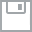
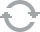
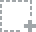
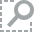
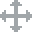
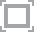
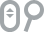
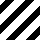
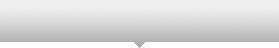
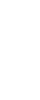
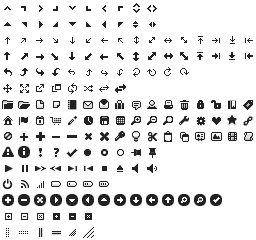
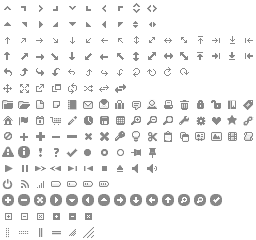
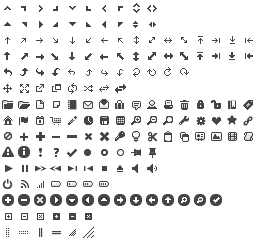
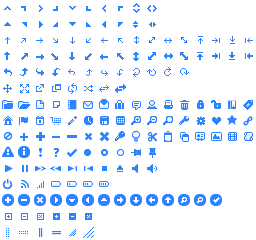
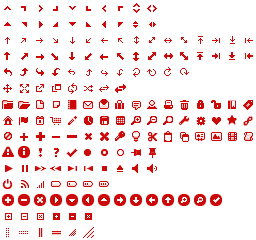
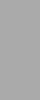
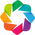
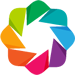

In [9]:
# plotting 
from bokeh.charts import Histogram, defaults
from bokeh._legacy_charts import HeatMap
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import Range1d
from bokeh.palettes import YlGn9 as palette
output_notebook()
defaults.width = 600
defaults.height = 300

#h = Histogram(df_paper['PubYear'], title= conf + " paper published by year")
#h.x_range = Range1d(df_paper['PubYear'].min(), df_paper['PubYear'].max())
#show(h)

In [10]:
# try to plot with seaborn

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [11]:
#ax = sns.barplot(data=df_paper['PubYear'].value_counts(sort=True) )

In [12]:
print('{} paper papers from {} to {}, citing {} others, avg {:0.2f} references per paper'.format(
        len(df_paper), df_paper['PubYear'].min(), df_paper['PubYear'].max(), len(df_citing), len(df_citing)/len(df_paper)))
grouped_citing = df_citing.groupby(['PaperPubYear'], sort=True)
grouped_citing.count()
len(grouped_citing)

531 paper papers from 2008 to 2015, citing 11334 others, avg 21.34 references per paper


8

In [13]:
refyear_citing = df_citing.groupby(['PaperPubYear', 'RefPubYear'], sort=True)
refyear_citing['RefID'].count()
np.unique(df_citing['PaperPubYear'] )
np.unique(df_citing['RefPubYear'] )

array([1906, 1908, 1918, 1927, 1933, 1934, 1935, 1938, 1944, 1946, 1947,
       1948, 1949, 1950, 1951, 1952, 1953, 1955, 1956, 1957, 1958, 1959,
       1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015])

In [14]:
minyear = 1904
maxyear = 2015
refpubyear_count = pd.DataFrame(data=None, index=np.unique(df_citing['RefPubYear'] ), 
                                    columns=np.unique(df_citing['PaperPubYear']), dtype='int32')
for name, gf in grouped_citing:
    #grouped_citing.RefPubYear
    refpubyear_count[name] = gf['RefPubYear'].value_counts(sort=True)
    print("{}: {} references across {} years".format(name, len(gf), len(gf['RefPubYear'].value_counts())) )
    

2008: 744 references across 50 years
2009: 1095 references across 52 years
2010: 1285 references across 57 years
2011: 2409 references across 50 years
2012: 1598 references across 54 years
2013: 1889 references across 54 years
2014: 1515 references across 54 years
2015: 799 references across 60 years


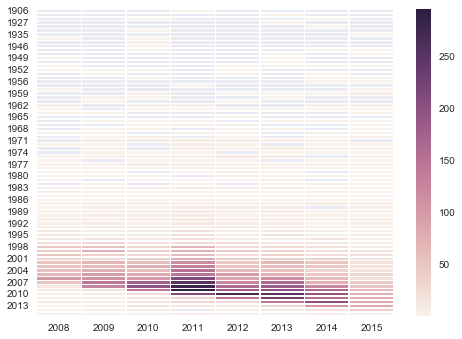

In [15]:
sns.heatmap(refpubyear_count, linewidths=.5, yticklabels=3)

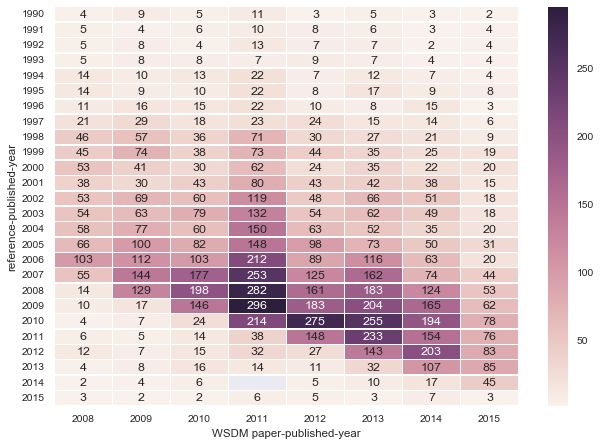

In [16]:
#sns.set_context("talk")
sns.set_context("talk", font_scale=0.8) #rc={"lines.linewidth": 2.5}
sns.heatmap(refpubyear_count.loc[1990:2015], linewidths=.5, annot=True, fmt=".0f") # annot=True, fmt="d", 
sns.axlabel(conf + ' paper-published-year', 'reference-published-year')

In [17]:
print('{} paper papers from {} to {}, cited {} time, avg {:0.2f} cites per paper'.format(
        len(df_paper), df_paper['PubYear'].min(), df_paper['PubYear'].max(), len(df_cited), len(df_cited)/len(df_paper)))
grouped_cited = df_cited.groupby(['RefPubYear'], sort=True)
#print( grouped_cited.count() )
len(grouped_cited)

cite_pubyear_count = pd.DataFrame(data=None, index=np.unique(df_cited['PaperPubYear'] ), 
                                    columns=np.unique(df_cited['RefPubYear']), dtype='int32')
for name, gf in grouped_cited:
    cite_pubyear_count[name] = gf['PaperPubYear'].value_counts(sort=True)
    print("{}: {} citations across {} years".format(name, len(gf), len(gf['PaperPubYear'].value_counts())) )
 

531 paper papers from 2008 to 2015, cited 9771 time, avg 18.40 cites per paper
2008: 2178 citations across 29 years
2009: 1705 citations across 38 years
2010: 2097 citations across 24 years
2011: 2035 citations across 22 years
2012: 970 citations across 14 years
2013: 653 citations across 13 years
2014: 112 citations across 4 years
2015: 21 citations across 2 years


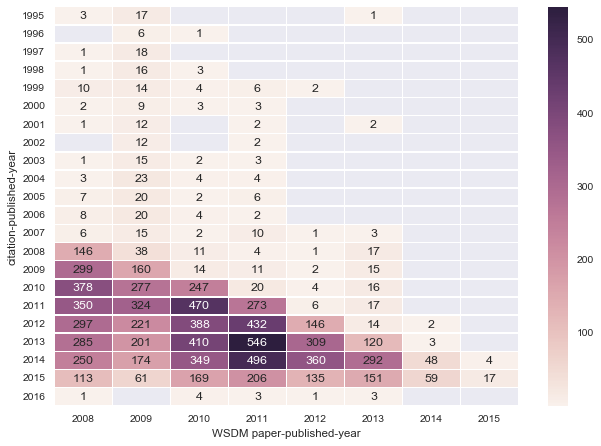

In [18]:
sns.set_context("talk", font_scale=0.8) #rc={"lines.linewidth": 2.5}
sns.heatmap(cite_pubyear_count.loc[1995:2016], linewidths=.5, annot=True, fmt=".0f") # annot=True, fmt="d", 
sns.axlabel(conf + ' paper-published-year', 'citation-published-year')

In [19]:
""" template for left joins
dfx_cited = df_cited.merge(df_paper[['PaperID', 'PubYear', 'ConfID']], 
                           left_on="RefID", right_on='PaperID', how='left') 
dfx_cited.drop('PaperID_y', axis=1, inplace=True)
dfx_cited = dfx_cited.rename(columns = {'PubYear':'RefPubYear', 'ConfID':"RefConfID", "PaperID_x":"PaperID"})
"""
# conf_df = pd.read_table(conf_file, header=None, names=['ConfID', 'Abbrv', 'FullName'])
dfx_citing = df_citing.merge(df_venue, left_on='RefVenueID', right_on='VenueID', how='left')
dfx_citing.drop('VenueID', axis=1, inplace=True)
dfx_citing = dfx_citing.rename(columns = {'VenueName':'RefVenueName'})

dfx_citing.head(10)

,PaperID,RefID,PaperPubYear,PaperConfID,RefPubYear,RefVenueID,RefVenueName
0,00920FBF,5DDA7CD0,2013,42C7B402,2011,,NaN
1,0146208B,5AC77E35,2014,42C7B402,2010,43FD776C,SIGIR
2,02118445,5D19D8E9,2014,42C7B402,1999,,NaN
3,023CDD97,02BD2F13,2011,42C7B402,2004,446908FE,CoopIS
4,023CDD97,5AB0E8A0,2011,42C7B402,2007,43FD776C,SIGIR
5,026DB22C,6853506F,2011,42C7B402,2011,,NaN
6,02762C04,042C17D8,2014,42C7B402,1996,,NaN
7,02B43BC3,599DA1B7,2014,42C7B402,2008,436976F3,KDD
8,02F40B9C,6C656A1F,2013,42C7B402,2012,,NaN
9,0309C757,597910FD,2010,42C7B402,1995,0B8A7A9E,IEEE Transactions on Aerospace and Electronic ...


In [20]:
is_empty = dfx_citing['RefVenueID'] == ''
is_empty.value_counts()

False    8320
True     3014
Name: RefVenueID, dtype: int64

In [21]:
dfx_citing_valid = dfx_citing[dfx_citing['RefVenueID'] != '']
dfx_citing_valid.tail()

,PaperID,RefID,PaperPubYear,PaperConfID,RefPubYear,RefVenueID,RefVenueName
11329,7063EDDC,6C42518D,2012,42C7B402,2008,42C7B402,WSDM
11330,706CEC6E,6C56B2AA,2013,42C7B402,2009,0AAA0D31,IEEE Computer
11331,707426BA,5BCCB0AB,2011,42C7B402,2004,062B05D6,Communications of The ACM
11332,7097922B,5A161207,2013,42C7B402,2008,42C7B402,WSDM
11333,7097922B,5C2059B0,2013,42C7B402,2012,06CB0ABA,Europhysics Letters (epl)


In [22]:
venue_name = list(dfx_citing_valid['RefVenueName'].unique())

grouped_citing = dfx_citing_valid.groupby(['PaperPubYear'], sort=True)
#print( grouped_citing.count() )
#len(grouped_cited)

citing_venue_count = pd.DataFrame(data=None, index = venue_name, 
                                    columns=np.unique(dfx_citing_valid['PaperPubYear']), dtype='int32')
for name, gf in grouped_citing:
    #grouped_citing.RefPubYear
    citing_venue_count[name] = gf['RefVenueName'].value_counts(sort=True)
    #print (citing_venue_count[name][citing_venue_count[name].notnull()])
    print("{}: {} references across {} venues".format(name, len(gf), citing_venue_count[name].notnull().sum() ) )
    #break
 


2008: 510 references across 136 venues
2009: 803 references across 155 venues
2010: 933 references across 156 venues
2011: 1854 references across 252 venues
2012: 1213 references across 217 venues
2013: 1392 references across 246 venues
2014: 1063 references across 212 venues
2015: 552 references across 158 venues


In [23]:
total_cnt = dfx_citing_valid.groupby(['RefVenueName']).count()['PaperID'].copy()
total_cnt.head(10)
total_cnt.sort_values(ascending=False, inplace=True)

['SIGIR', 'WWW', 'KDD', 'WSDM', 'CIKM', 'NIPS', 'Clinical Orthopaedics and Related Research', 'ICML', 'CHI', 'ICDM', 'ACM Transactions on Information Systems', 'ACL', 'Communications of The ACM', 'Journal of Machine Learning Research', 'EMNLP', 'Information Processing and Management', 'Journal of the Association for Information Science and Technology', 'AAAI', 'Journal of the ACM', 'VLDB', 'Proceedings of The Vldb Endowment', 'Proceedings of the National Academy of Sciences of the United States of America', 'SIGMOD', 'Sigir Forum', 'ICWSM', 'Information Retrieval', 'WI', 'IEEE Transactions on Knowledge and Data Engineering', 'Machine Learning', 'SODA', 'Journal of the American Statistical Association', 'UAI', 'EC', 'STOC', 'World Wide Web', 'Technometrics', 'Sigkdd Explorations', 'NAACL', 'IEEE Transactions on Pattern Analysis and Machine Intelligence', 'RecSys', 'IEEE Computer', 'MM', 'Science', 'Computer Networks', 'Physical Review E', 'Computer Networks and Isdn Systems', 'ACM Compu

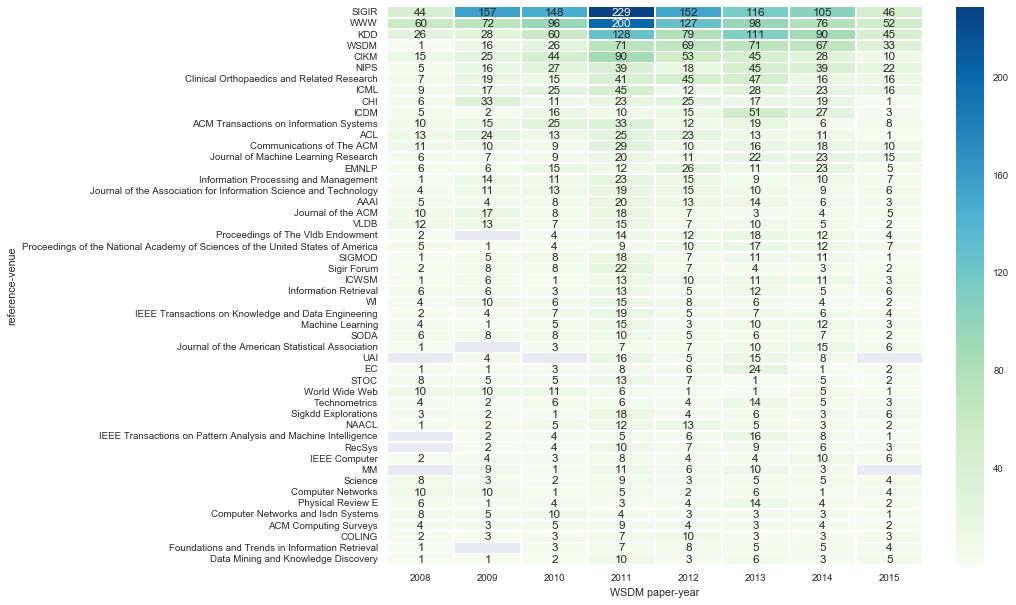

In [24]:
#total_cnt.head(50)
#print(list(total_cnt.index))
#for s in total_cnt:
    #print('{} \t {}'.format(srs, idx))
#    print(s)

# figure out the top X venues for display
topK = 50
venue_list = list(total_cnt.index)[:topK]
print(venue_list)


sns.set_context("talk", font_scale=0.75)
plt.figure(figsize=(12, 10))
sns.heatmap(citing_venue_count.loc[venue_list], linewidths=.5, annot=True, fmt=".0f", cmap="GnBu") 
sns.axlabel(conf + ' paper-year', 'reference-venue')

In [25]:
df_cited.head()

,PaperID,RefID,RefPubYear,RefConfID,PaperPubYear,PaperVenueID
0,0044F979,0BB86011,2012,42C7B402,2014,
1,0045676D,6D0AACE5,2011,42C7B402,2015,
2,0052501A,023CDD97,2011,42C7B402,2014,43F44683
3,00587FAC,674A45B9,2010,42C7B402,2013,
4,00772E24,6090C39B,2010,42C7B402,2014,43FD776C


In [26]:
# now the citing articles

dfx_cited = df_cited.merge(df_venue, left_on='PaperVenueID', right_on='VenueID', how='left')
dfx_cited.drop('VenueID', axis=1, inplace=True)
dfx_cited = dfx_cited.rename(columns = {'VenueName':'PaperVenueName'})

print( dfx_cited.head() )

is_empty = dfx_cited['PaperVenueID'] == ''
print( is_empty.value_counts() ) 

dfx_cited_valid = dfx_cited[dfx_cited['PaperVenueID'] != '']
dfx_cited_valid.tail()

    PaperID     RefID  RefPubYear RefConfID  PaperPubYear PaperVenueID  \
0  0044F979  0BB86011        2012  42C7B402          2014                
1  0045676D  6D0AACE5        2011  42C7B402          2015                
2  0052501A  023CDD97        2011  42C7B402          2014     43F44683   
3  00587FAC  674A45B9        2010  42C7B402          2013                
4  00772E24  6090C39B        2010  42C7B402          2014     43FD776C   

  PaperVenueName  
0            NaN  
1            NaN  
2          APWeb  
3            NaN  
4          SIGIR  
False    4958
True     4813
Name: PaperVenueID, dtype: int64


,PaperID,RefID,RefPubYear,RefConfID,PaperPubYear,PaperVenueID,PaperVenueName
9765,7063EDDC,6C42518D,2008,42C7B402,2012,42C7B402,WSDM
9766,70696E30,5A020009,2009,42C7B402,2010,0418943F,Vision Research
9767,706A368A,5A24B5F8,2009,42C7B402,2010,4558D729,CHI
9768,707C8B4B,5F0CE872,2008,42C7B402,2009,07179FAA,Journal of Machine Learning Research
9770,7097922B,5A161207,2008,42C7B402,2013,42C7B402,WSDM


In [27]:
grouped_cited = dfx_cited_valid.groupby(['RefPubYear'], sort=True)

cited_venue_count = pd.DataFrame(data=None, index = venue_name, 
                                    columns=np.unique(dfx_cited_valid['RefPubYear']), dtype='int32')
for name, gf in grouped_cited:
    #grouped_citing.RefPubYear
    cited_venue_count[name] = gf['PaperVenueName'].value_counts(sort=True)
    print("{}: {} citiations across {} venues".format(name, len(gf), cited_venue_count[name].notnull().sum() ) )
    

2008: 1162 citiations across 145 venues
2009: 1024 citiations across 121 venues
2010: 1003 citiations across 115 venues
2011: 945 citiations across 93 venues
2012: 434 citiations across 76 venues
2013: 328 citiations across 57 venues
2014: 49 citiations across 18 venues
2015: 13 citiations across 5 venues


PaperVenueName
WWW                                                                  399
SIGIR                                                                391
WSDM                                                                 354
KDD                                                                  219
CIKM                                                                 103
Information Processing and Management                                 97
Expert Systems With Applications                                      89
WI                                                                    79
ICDM                                                                  75
Information Retrieval                                                 68
ACM Transactions on Information Systems                               64
Journal of the Association for Information Science and Technology     63
Proceedings of The Vldb Endowment                                     60
Clinical Orthopaedics and Related Re

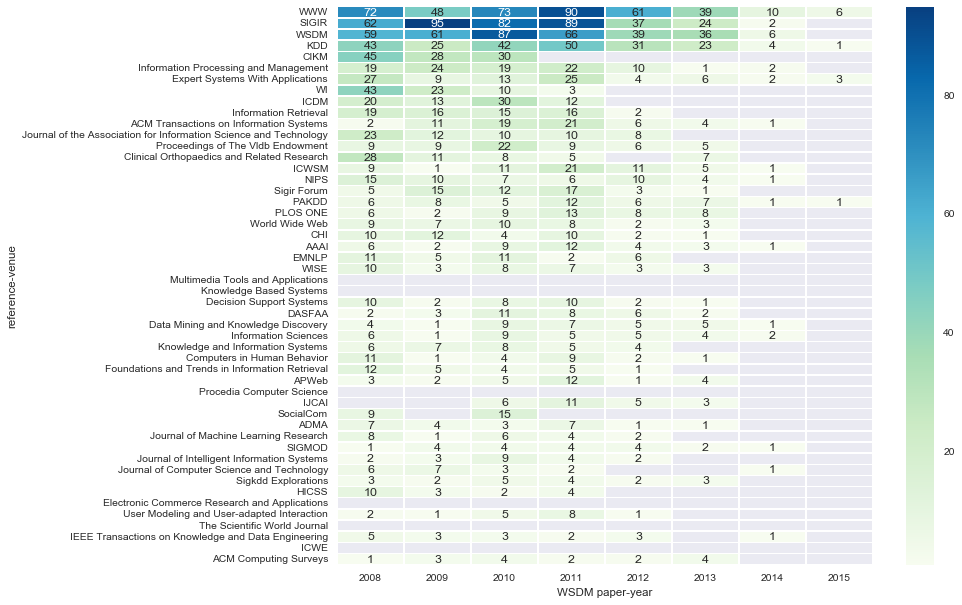

In [28]:
total_cnt = dfx_cited_valid.groupby(['PaperVenueName']).count()['PaperID'].copy()
total_cnt.sort_values(ascending=False, inplace=True)
print(total_cnt.head(25), total_cnt.tail())

topK = 50
venue_list = list(total_cnt.index)[:topK]
print(venue_list)

sns.set_context("talk", font_scale=0.8)
plt.figure(figsize=(12, 10))
sns.heatmap(cited_venue_count.loc[venue_list], linewidths=.5, annot=True, fmt=".0f", cmap="GnBu") 
sns.axlabel(conf + ' paper-year', 'reference-venue')    

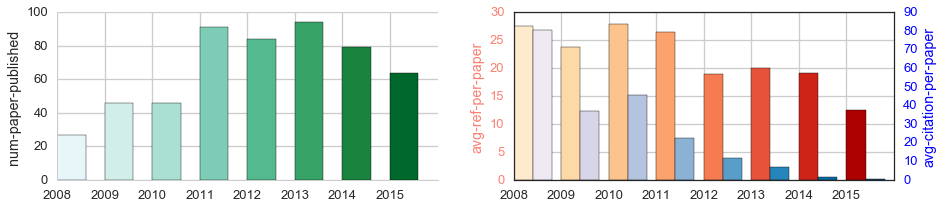

In [29]:
# data profile plots

plt.figure(figsize=(15, 3))
# # of papers over years; # of references and # of citations over years
# # of citings over years, w/wo venues; # of citing venues over years
# # of citations over publication years, w/wo venues; # of venues over years
"""for year in range(2008, 2016): """

years = range(2008, 2016)
bar_colrs1 = sns.color_palette("BuGn", len(years))
bar_colrs2 = sns.color_palette("OrRd", len(years))
bar_colrs3 = sns.color_palette("PuBu", len(years))
x_pos = [x+1 for x in range(len(years))]

sns.set_context("talk", font_scale=1.)
sns.set_style("whitegrid")
sns.despine()

ax = plt.subplot(1, 2, 1)
rects1 = ax.bar(x_pos, np.array(df_paper['PubYear'].value_counts(sort=False)), width=.6, color=bar_colrs1)
ax.set_ylabel('num-paper-published')
tk1 = plt.xticks(x_pos, years) #, rotation='vertical'

"""# of references and # of citations over years"""
ax2 = plt.subplot(1, 2, 2)

sns.set_style("white")
sns.despine()

ref_pp = np.array( df_citing['PaperPubYear'].value_counts()/df_paper['PubYear'].value_counts() )
cit_pp = np.array( df_cited['RefPubYear'].value_counts()/df_paper['PubYear'].value_counts() )
rects2 = ax2.bar(x_pos, ref_pp, width=.4, color=bar_colrs2)

ax2a = ax2.twinx()
rects2a = ax2a.bar([x+.4 for x in x_pos], cit_pp, width=.4, color=bar_colrs3)

tk2 = plt.xticks(x_pos, years) #, rotation='vertical'
ax2.set_ylabel('avg-ref-per-paper', color='salmon')
ax2a.set_ylabel('avg-citation-per-paper', color='b')
for tl in ax2.get_yticklabels():
    tl.set_color('salmon')
for tl in ax2a.get_yticklabels():
    tl.set_color('b')


[510, 803, 933, 1854, 1213, 1392, 1063, 552] [234, 292, 352, 555, 385, 497, 452, 247]


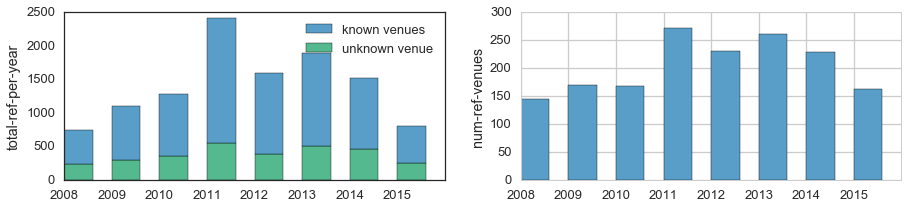

In [30]:
"""# of citings over years, w/wo venues; # of citing venues over years"""    
plt.figure(figsize=(15, 3))

ax3 = plt.subplot(1, 2, 1)
sns.set_style("whitegrid")

citing_not_null = [] #np.zeros((1, len(years)), dtype=np.int)
citing_num_null = [] #np.zeros((len(years), 1), dtype=np.int)
cnt = 0 
for name, gf in df_citing.groupby(['PaperPubYear']):
    #print(gf.head())
    #print(len(gf), len ( gf['RefVenueID'][gf['RefVenueID'] != ''] ), len ( gf['RefVenueID'][gf['RefVenueID'] == ''] )) 
    citing_not_null.append( len ( gf['RefVenueID'][gf['RefVenueID'] != ''] ) )
    citing_num_null.append( len ( gf['RefVenueID'][gf['RefVenueID'] == ''] ) )
    
print(citing_not_null, citing_num_null)    

rects3a = ax3.bar(x_pos, citing_num_null, width=.6, color=bar_colrs1[4])
rects3b = ax3.bar(x_pos, citing_not_null, width=.6, color=bar_colrs3[4], bottom=citing_num_null)

tk3 = plt.xticks(x_pos, years) 
ax3.set_ylabel('total-ref-per-year')
plt.legend((rects3b[0], rects3a[0]), ('known venues', 'unknown venue'))


ax4 = plt.subplot(1, 2, 2)
sns.set_style("whitegrid")

venue_counts = []
for name, gf in df_citing[df_citing['RefVenueID'] != ''].groupby(['PaperPubYear']):
    venue_counts.append( len( gf['RefVenueID'].value_counts() ) )

rects4 = ax4.bar(x_pos, venue_counts, width=.6, color=bar_colrs3[4])

tk4 = plt.xticks(x_pos, years) 
ax4.set_ylabel('num-ref-venues')



2178 1162 1016
1705 1024 681
2097 1003 1094
2035 945 1090
970 434 536
653 328 325
112 49 63
21 13 8
[1162, 1024, 1003, 945, 434, 328, 49, 13] [1016, 681, 1094, 1090, 536, 325, 63, 8]


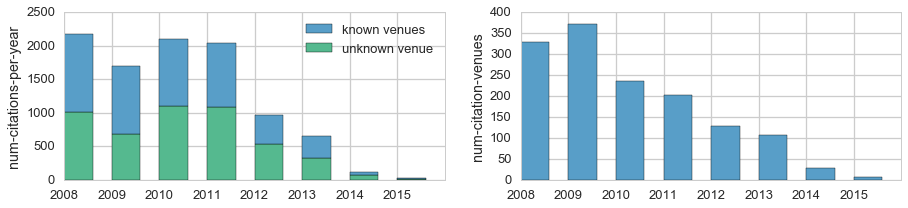

In [31]:
"""# of citations over publication years, w/wo venues; # of venues over years"""

plt.figure(figsize=(15, 3))

ax5 = plt.subplot(1, 2, 1)
sns.set_style("whitegrid")

citations_not_null = [] 
citations_num_null = [] 
for name, gf in df_cited.groupby(['RefPubYear']):
    #print(gf.head())
    print(len(gf), len ( gf['PaperVenueID'][gf['PaperVenueID'] != ''] ), len ( gf['PaperVenueID'][gf['PaperVenueID'] == ''] )) 
    citations_not_null.append( len ( gf['PaperVenueID'][gf['PaperVenueID'] != ''] ) )
    citations_num_null.append( len ( gf['PaperVenueID'][gf['PaperVenueID'] == ''] ) )
    
print(citations_not_null, citations_num_null)    

rects5a = ax5.bar(x_pos, citations_num_null, width=.6, color=bar_colrs1[4])
rects5b = ax5.bar(x_pos, citations_not_null, width=.6, color=bar_colrs3[4], bottom=citations_num_null)

tk5 = plt.xticks(x_pos, years) 
ax5.set_ylabel('num-citations-per-year')
plt.legend((rects5b[0], rects5a[0]), ('known venues', 'unknown venue'))

ax6 = plt.subplot(1, 2, 2)
sns.set_style("whitegrid")

venue_counts = []
for name, gf in df_cited[df_cited['PaperVenueID'] != ''].groupby(['RefPubYear']):
    venue_counts.append( len( gf['PaperVenueID'].value_counts() ) )

rects6 = ax6.bar(x_pos, venue_counts, width=.6, color=bar_colrs3[4])

tk6 = plt.xticks(x_pos, years) 
ax6.set_ylabel('num-citation-venues')

In [43]:
import networkx as nx

topK = 25

""" generate citation venue graph """
citation_venue_cnt = dfx_cited_valid.groupby(['PaperVenueName']).count()['PaperID'].copy()
citation_venue_cnt.sort_values(ascending=False, inplace=True)
citeG = nx.DiGraph()

#for i in range(topK):
for v, c in zip(list(citation_venue_cnt.head(25).index), list(citation_venue_cnt.head(25))):
    citeG.add_edge(v, 'WSDM', weight= int(c) )

nx.write_graphml(citeG, os.path.join(data_dir, 'citeG.graphml'))

""" generate reference venue graph """ 
ref_venue_cnt = dfx_citing_valid.groupby(['RefVenueName']).count()['PaperID'].copy()
ref_venue_cnt.sort_values(ascending=False, inplace=True)
refG = nx.DiGraph()

#for i in range(topK):
for v, c in zip(list(ref_venue_cnt.head(topK).index), list(ref_venue_cnt.head(topK))):
    refG.add_edge('WSDM', v, weight=int(c) )

nx.write_graphml(citeG, os.path.join(data_dir, 'refG.graphml'))


In [44]:
len(citation_venue_cnt)

710

In [45]:
citation_venue_cnt.head(25)

PaperVenueName
WWW                                                                  399
SIGIR                                                                391
WSDM                                                                 354
KDD                                                                  219
CIKM                                                                 103
Information Processing and Management                                 97
Expert Systems With Applications                                      89
WI                                                                    79
ICDM                                                                  75
Information Retrieval                                                 68
ACM Transactions on Information Systems                               64
Journal of the Association for Information Science and Technology     63
Proceedings of The Vldb Endowment                                     60
Clinical Orthopaedics and Related Re

In [46]:
ref_venue_cnt.head(topK)

RefVenueName
SIGIR                                                                              997
WWW                                                                                781
KDD                                                                                567
WSDM                                                                               354
CIKM                                                                               310
NIPS                                                                               211
Clinical Orthopaedics and Related Research                                         206
ICML                                                                               175
CHI                                                                                135
ICDM                                                                               129
ACM Transactions on Information Systems                                            128
ACL                           